# Plot long-range coupling effects for words using in-house data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
code_dir = '/home/nblauch/git/imaging_neuro'
import sys
sys.path.append(code_dir)
from func.utils import plot_scatters, reject_df_outliers
from func import SUBNUMS_PAPER


In [2]:
all_results = pd.read_csv(f'{code_dir}/data/inhouse_fmri_text_network_mv-True.tsv', sep='\t')
# comment out the next two lines to use all subjects
all_results = all_results[all_results['subnum'].isin(SUBNUMS_PAPER)]
all_results = reject_df_outliers(all_results, m=3)
sub_inds = all_results.index.values

/home/nblauch/git/imaging_neuro/func/utils.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[is_outlier] = np.nan


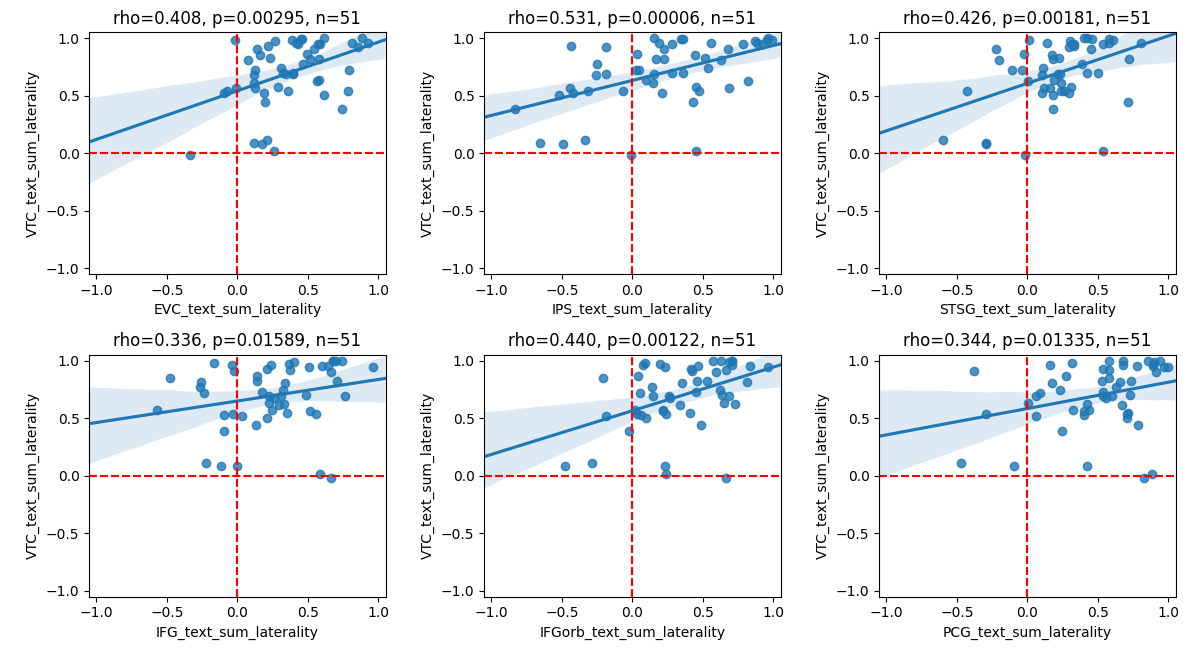

In [3]:
metric = 'sum'
sub1 = ''
sub2 = ''
# sub1 = '_even'
# sub2 = '_odd'
kws=dict(standardize=False, plot=True, show=False, nuis_in_name=False)

rois = ['EVC', 'IPS', 'STSG', 'IFG', 'IFGorb', 'PCG']
for hemi2 in ['laterality']: #, 'lh', 'rh']:
    layout = []
    for roi in rois:
        layout.append(
            (f'{roi}_text_{metric}_laterality'+sub1, f'VTC_text_{metric}_laterality'+sub2, [], [], None, 
                ))
    shape = (2,len(rois)//2)

    plot_scatters(layout, shape, all_results, fn=None, **kws)

# whole-brain parcel results

In [4]:
import pickle
atlas = '1000Parcels_Yan2023_Yeo2011_17Networks'
with open(f'{code_dir}/data/inhouse_long_range_laterality_{atlas}.pkl', 'rb') as f:
    data = pickle.load(f)

with open(f'{code_dir}/data/{atlas}_exclude_rois.pkl', 'rb') as f:
    exclude_rois = pickle.load(f)


/home/nblauch/anaconda3/envs/drive-suppress-brains/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


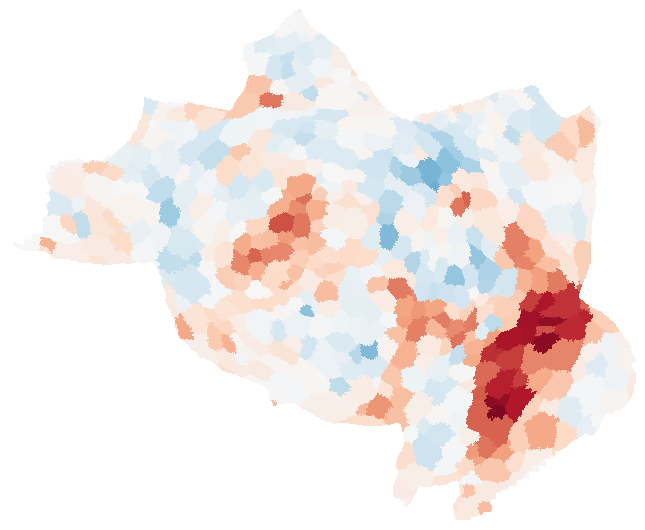

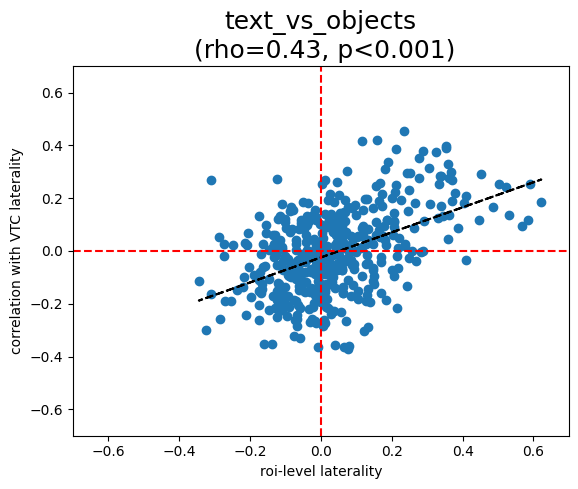

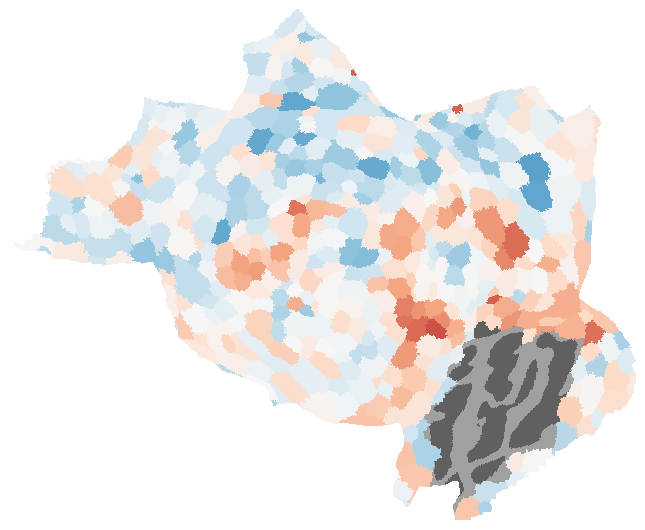

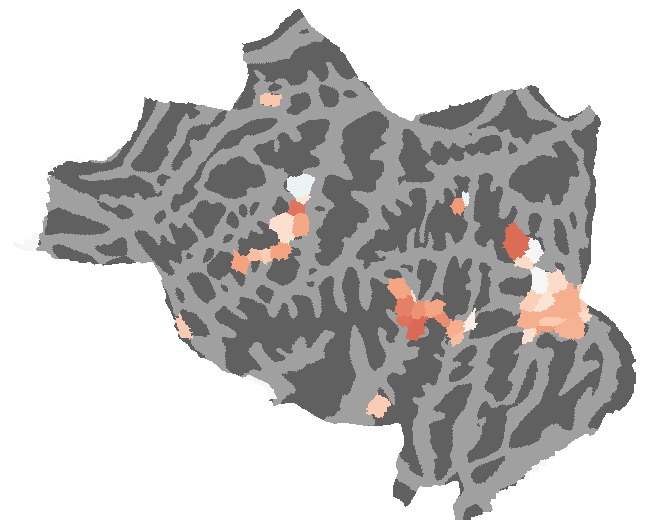

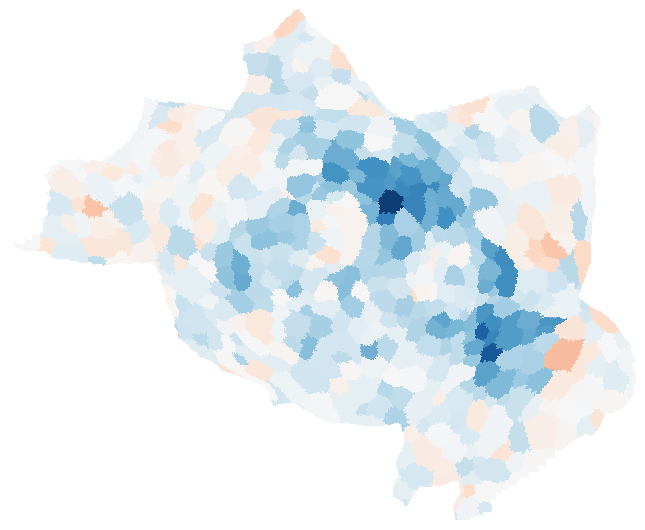

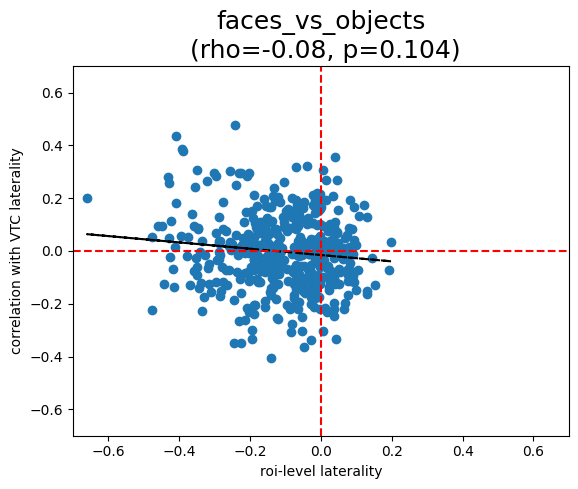

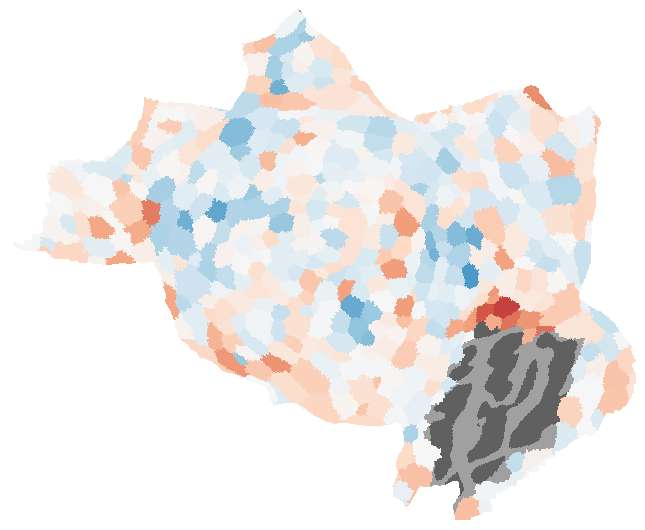

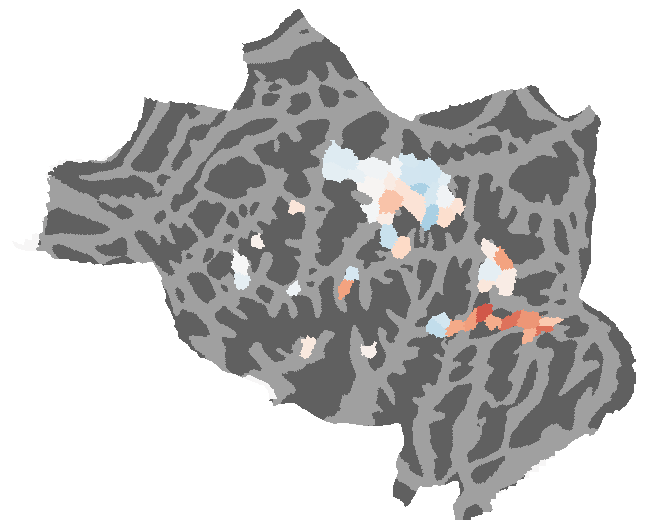

In [5]:
import cortex
from func.masking import get_annot, atlas_to_surf_map, find_overlapping_rois_group
from scipy.stats import spearmanr

atlas_split = 'odd'
vtc_split = 'even'  
for func_map in ['text_vs_objects', 'faces_vs_objects']:

    # find inds of bad rois
    inds = data[atlas_split][func_map]['inds']
    bad_inds = np.array([np.argwhere(inds == bad_roi) for bad_roi in exclude_rois if bad_roi in inds]).squeeze()
    good_inds = np.setdiff1d(np.arange(len(inds)), bad_inds)
    # just take first hemi: they are homotopic
    bad_inds_onehemi = bad_inds[:len(bad_inds)//2]
    good_inds_onehemi = np.setdiff1d(np.arange(len(inds)//2), bad_inds)

    datas = {}
    pyc_kws = dict(colorbar_location='left', cutout='LH', with_colorbar=False) # if func_map == 'text' else dict(colorbar_location='right', cutout='RH')

    surf_map = atlas_to_surf_map(data[atlas_split][func_map]['full_laterality'][sub_inds].mean(0), data[atlas_split][func_map]['inds'], get_annot(atlas))
    surf_data = cortex.Vertex(surf_map, subject='fsaverage', cmap='RdBu_r', vmin=-.7, vmax=.7)
    cortex.quickshow(surf_data, with_labels=False, with_rois=False, height=512, **pyc_kws)
    plt.show()
    datas[f'{func_map} roi-level laterality'] = surf_data

    roi_plus_atlas = np.hstack((np.array(data[vtc_split][func_map]['VTC_laterality'][sub_inds]).reshape(-1,1), data[atlas_split][func_map]['laterality'][sub_inds]))
    corrs = np.corrcoef(roi_plus_atlas.transpose())[1:,0]
    x = data[atlas_split][func_map]['laterality'][sub_inds][:,good_inds_onehemi].mean(0)
    y = corrs[good_inds_onehemi]
    # compute line of best fit and correlation stats
    m, b = np.polyfit(x, y, 1)
    r, p = spearmanr(x, y)
    if p <0.001:
        stat_str = f'rho={r:.2f}, p<0.001'
    else:
        stat_str = f'rho={r:.2f}, p={p:.3f}'    
    plt.plot(x, y, 'o')
    plt.plot(x, m*x + b, color='k', linestyle='--')
    plt.axhline(0, color='r', linestyle='--')
    plt.axvline(0, color='r', linestyle='--')
    plt.ylim(-.7, .7)
    plt.xlim(-.7, .7)
    plt.title(f'{func_map}\n ({stat_str})', fontsize=18)
    plt.xlabel('roi-level laterality')
    plt.ylabel('correlation with VTC laterality')
    plt.show()

    # now compute all the correlations
    corrs = np.hstack((corrs, corrs))
    # ensure no nans
    corrs[np.isnan(corrs)] = 0
    # set VTC to nan
    corrs[bad_inds] = np.nan

    surf_map = atlas_to_surf_map(corrs, data[atlas_split][func_map]['inds'], get_annot(atlas))
    surf_data = cortex.Vertex(surf_map, subject='fsaverage', cmap='RdBu_r', vmin=-.7, vmax=.7)
    cortex.quickshow(surf_data, with_labels=False, with_rois=False, with_curvature=True, height=512, **pyc_kws)
    plt.show()
    datas[f'{func_map} correlation between VTC and roi laterality'] = surf_data

    # mask this to only the top n lateralized rois outside of VTC: rightward for faces, leftwards for words
    n=50
    if 'text_vs' in func_map:
        sort_dir = -1
    else:
        sort_dir = 1
    sorted_inds = np.argsort(sort_dir*data[atlas_split][func_map]['full_laterality'][sub_inds].mean(0))
    top_inds = []
    for ind in sorted_inds:
        if ind in bad_inds:
            continue
        top_inds.append(ind)
        if len(top_inds) == n:
            break
    corrs_masked = corrs.copy()
    corrs_masked[np.setdiff1d(np.arange(len(corrs)), top_inds)] = np.nan
    surf_map = atlas_to_surf_map(corrs_masked, data[atlas_split][func_map]['inds'], get_annot(atlas))
    surf_data = cortex.Vertex(surf_map, subject='fsaverage', cmap='RdBu_r', vmin=-.7, vmax=.7)
    cortex.quickshow(surf_data, with_labels=False, with_rois=False, with_curvature=True, height=512, **pyc_kws)
    plt.show()
    datas[f'{func_map} correlation between VTC and roi laterality (top {n} lateralized rois)'] = surf_data